### ***Insights into academia***

* How has the open-access publishing grown over the years? 
  * Does it improve the quality of research? How well does open-access translate to the quantity of research? 
  * Can we devise a normalized research quality metric based on the information?
  * To what extend does the open-access benefit the community, in particular, the developing nations? 

In an attempt to make federally funded research open, initiated by scientists and researchers, Library Genesis is a database for articles and books on various topics, which allows free access to content that is otherwise paywalled or not digitized elsewhere. 

> A sister site, Sci-Hub's, founder *Alexandra Elbakyan* was listed by *Nature*, in 2016, among the **top ten people that mattered in science**. US ranks *second* in the terms of web-traffic on Sci-Hub and related websites. 
>
>As per wikipedia: Elbakyan's Sci-Hub is widely used in both developed and developing countries, serving over 200,000 requests per day as of February 2016. 
> * How has the inception of Sci-Hub affected the quality/quantity of research in developing nations? Do more authors go on to write high quality papers in their respective fields? 
> * Has the number of papers cited per paper increased (with access to large number of papers and therefore more information)? 
> * Does their sphere of influence increase? Do they get more post-doctoral offers abroad? (This can be partially answered by looking at the collaboration graph of a researcher)

In this work, we shall restrict our attention to academic papers. Our study shall be based on ***database record*** of academic papers, ***not*** the actual academic papers themselves. The database, publicly available at http://booksdescr.org/dbdumps/scimag, contains over 70 million records of academic papers. It includes information of paper titles, author list, doi, etc. which in turn can be used to query citation information, abstract, etc. from Google Scholar, Pubmed, Researchgate, etc. The important point is: ***the database is relatively unanalyzed, and LibGen is perhaps the biggest such record of academic papers!*** The databse is incredibly information rich, and can be utilized to reveal insights into publishing. 

* How does the paper quality of a researcher changes over time in various fields? For example: It is widely believed in Mathematics that ground-breaking contribution are from researchers below 30-35 years of age. How does that vary in other fields, by country of origin, by institution, etc? The intention of this study shall be to provide answers backed by analysis on actual data.

> Important Note:
>* Our study shall be based on ***database record*** of academic papers, ***not*** the actual academic papers themselves. LibGen has been the subject of various formal academic studies. Few of them are listed below:
>  * Karaganis, Joe. *Shadow libraries: access to knowledge in global higher education*. MIT Press, 2018.
>  * Cabanac, Guillaume. *Bibliogifts in LibGen? A study of a text‐sharing platform driven by biblioleaks and crowdsourcing.* Journal of the Association for Information Science and Technology 67, no. 4 (2016): 874-884.   

Data presentation: 
* The intention will be to generate an interactive insightful tool on academic publishing (see for example: Hans Rosling's https://www.gapminder.org/tools on socio-economic growth across the globe over years).

Tools:
* Python: Apache-Spark's ML on large datasets, MySQL, NetworkX, etc; Javascript: d3js

In [20]:
import numpy as np
import itertools as it
from collections import defaultdict
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.dpi']= 300
import matplotlib.pyplot as plt

import pyspark
import MySQLdb
import requests

In [2]:
# Connect to LibGen's publicly available database
db=MySQLdb.connect(user="jaiswal0", passwd="dInc#2019", db="8k")

In [3]:
# We shall analyze a subportion (~10.8 million) of the entire database (>70 million).
num_entries = pd.read_sql('SELECT COUNT(*) FROM scimag', con=db)
print(num_entries)

   COUNT(*)
0  10795980


In [4]:
# What are the columns
cols = pd.read_sql('''SELECT column_name FROM information_schema.columns where table_name='scimag' AND table_schema='2k' ''', con=db)
print(cols['COLUMN_NAME'].to_string(index=False).replace("\n", ""))

 AbstractURL Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  Author      Day         DOI         DOI2        Filesize    First_page  ID          ISBN        ISSNE       ISSNP       Issue       Journal     JOURNALID   Last_page   MD5         Month       PII         PMC         PubmedID    TimeAdded   Title       visible     Volume      Year       


In [5]:
# Find entries with a PubmedID
art_pubmed = pd.read_sql('''
    SELECT Author, PubmedID, Year, Attribute1 FROM scimag 
    where PubmedID>0 
''', con=db)
print(art_pubmed[:10])

                                                                                                                                                                                                                      Author  \
0  Katherine M. Hegmann; Aimee S. Spikes; Avi Orr-Urtreger; Lisa G. Shaffer                                                                                                                                                    
1  Vijay Tonk; Nancy R. Schneider; Mauricio R. Delgado; Jen-i Mao; Roger A. Schultz                                                                                                                                            
2  Selma Siegel Witchel; Peter A. Lee; Massimo Trucco                                                                                                                                                                          
3  Orit Reish; Susan A. Berry; Gordon Dewald; Richard A. King                                           

In [6]:
# Number of entries with a pubmedID
len(art_pubmed)

1616069

### Nearly 1.6 million entries have a *pubmedID*. Having identified this information, we can query abstract information from NIH database
*The abstract information can be utilized to build bi-grams, and potentially a ML model for writing paper abstracts!*

In [7]:
url = '''https://api.ncbi.nlm.nih.gov/lit/ctxp/v1/pubmed/?format=medline&id={id}'''
headers = {'User-Agent': 'Hydra/1.3.15'}

def load_medline(info):
    data = info.split("\n");
    infodict = defaultdict(lambda: None)
    temp = ['', '']
    for line in data:
        if not line: continue
        if line[4]=="-":
            if temp[0]!='':
              if temp[0] in infodict:
                infodict[temp[0]][-1] = temp[1];            
              else:
                infodict[temp[0]] = [temp[1]]; 
            temp = [line[:4].strip(), line[5:]]
            if temp[0] in infodict:
              infodict[temp[0]].append(temp[1]);
            else:
              infodict[temp[0]] = [temp[1]];
        else:
            temp[1] += ' ' + line.strip() + ' '    
            continue
    return dict({"Abstract": infodict["AB"]})

def fetch_pubmed(pubmedID):
    api_url = url.format(id=pubmedID)
    print(api_url)
    response = requests.get(api_url, headers=headers)
    if response.status_code == 200:
        return load_medline(response.content.decode('utf-8'))
    else:
        return None

# for first three entries fetch abstract
for entry in range(3): 
    pubmedID = art_pubmed['PubmedID'][entry]
    info = fetch_pubmed(pubmedID)
    #print(info)
    if info:
        print(info["Abstract"], art_pubmed['Year'][entry])
        art_pubmed['Attribute1'][entry] = info["Abstract"]


https://api.ncbi.nlm.nih.gov/lit/ctxp/v1/pubmed/?format=medline&id=8741910
[' A genetics evaluation was requested for a 6-week-old infant with multiple congenital  malformations including mild craniofacial anomalies, truncal hypotonia, hypospadias,  and a ventriculoseptal defect. Blood obtained for chromosome analysis revealed an  abnormal chromosome 4. Paternal chromosome analysis showed a 46,XY, inv ins  (3;4)(p21.32;q25q21.2), inv(4)(p15.3q21.2) karyotype. Therefore, the proband\'s  chromosome 4 was the unbalanced product of this insertional translocation from the  father resulting in partial monosomy 4q. Additionally, the derivative 4 had a  pericentric inversion which was also seen in the father\'s chromosome 4. During  genetic counseling, the proband\'s 2-year-old brother was evaluated. He was not felt  to be abnormal in appearance, but was described as having impulsive behavior.  Chromosome analysis on this child revealed 46,XY,der(3)inv  ins(3;4)(p21.32;q25q21.2)pat. This karyo

We shall come back to this later! First let us extract some uncanny information ... 

### ***What are the most common author names in academia?***

In [8]:
# Find names of all the authors "individually" (we split on delimiter ';')
authors = pd.read_sql('''
    select T.Author, COUNT(*) from (
        select scimag.ID, SUBSTRING_INDEX(SUBSTRING_INDEX(REPLACE(
                                LOWER(scimag.Author), ';', ' '), ' ', numbers.n), ' ', -1
                            ) Author
        from (
            SELECT 1 n UNION ALL SELECT 2 UNION ALL 
            SELECT 3 UNION ALL SELECT 4 UNION ALL SELECT 5 UNION ALL 
            SELECT 6 UNION ALL SELECT 7 UNION ALL SELECT 8 UNION ALL 
            SELECT 9 UNION ALL SELECT 10 UNION ALL SELECT 11 UNION ALL 
            SELECT 12
        ) numbers INNER JOIN scimag
              ON CHAR_LENGTH(Author)
             -CHAR_LENGTH(REPLACE(REPLACE(Author, ';', ' '), ' ', ''))>=numbers.n-1
    ) 
    as T
    where LENGTH(TRIM(T.Author))>2
    GROUP BY T.Author
    HAVING COUNT(*) > 0
    ORDER BY COUNT(*) DESC
''', con=db)

In [9]:
len(authors)

1562273

In [10]:
authors['Author'][0], authors['COUNT(*)'][0]

('dr.', 194438)

### Ofcourse "Dr." is the most frequent ... 

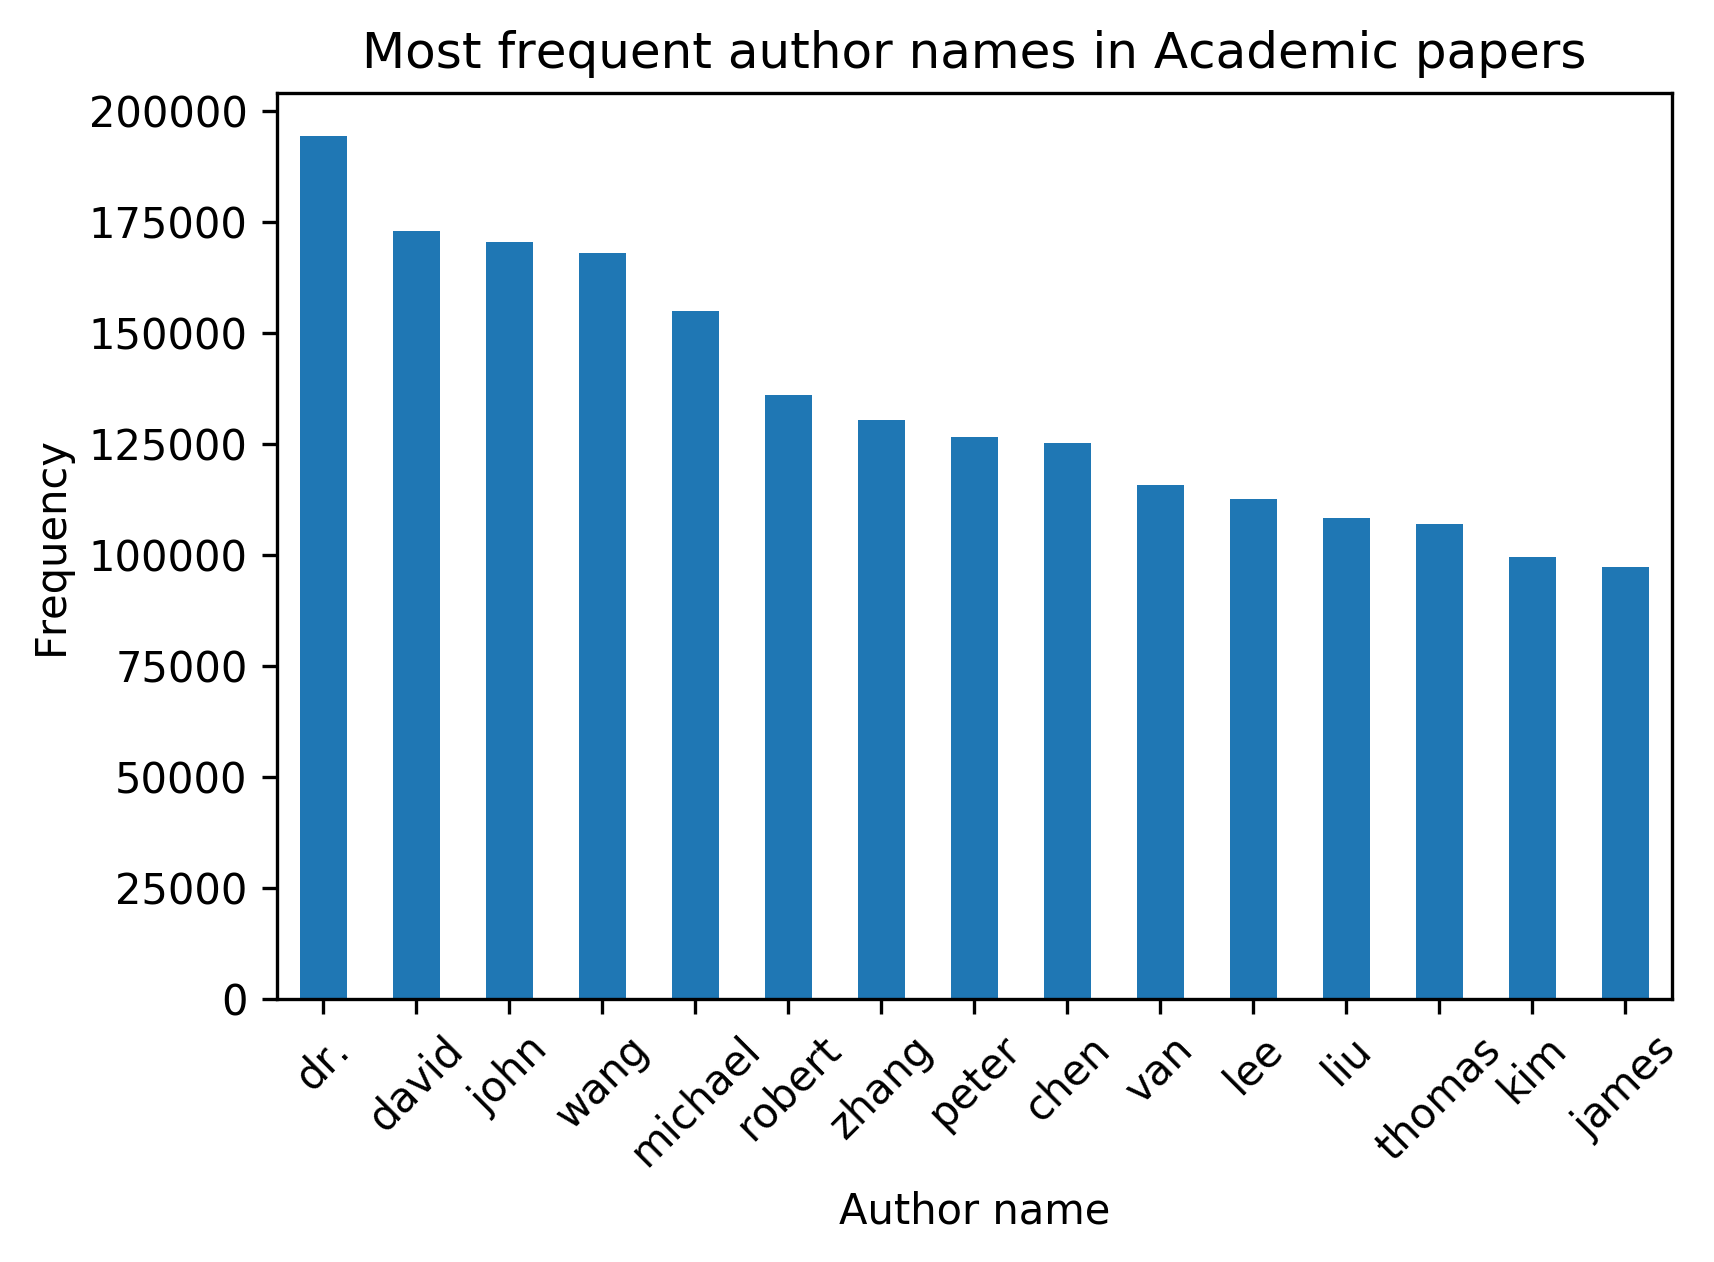

In [21]:
def logspace(start, end, numpoints):
    return 10**np.linspace(np.log10(start),np.log10(end),numpoints)

ax = authors[:15].plot(x='Author', y='COUNT(*)', 
                       kind='bar', rot=45, legend=False) 
#ax.set_yticks(logspace(5e4, 2e5, 5))
ax.set_xlabel("Author name");
ax.set_ylabel("Frequency");
ax.set_title("Most frequent author names in Academic papers");

### Find female scientists and researchers
We use a ML classification model for identifying gender based on author's name: https://github.com/ellisbrown/name2gender
The classification accuracy will be determined on the dataset on which name2gender was trained. But, any other model should work.

In [12]:
import sys
import pickle
import unicodedata
import string
sys.path.append('./name2gender/')
sys.path.append('./name2gender/naive_bayes/')

In [13]:
weights = 'name2gender/weights/nb/naive_bayes_weights_jup'

def clean_str(s):
    uncoded = ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in string.ascii_letters
    )
    return uncoded.lower()

def time_since(since):
    now = time.time()
    s = now - since
    hours, rem = divmod(now-since, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}h {:0>2}m {:0>2}s".format(int(hours), int(minutes), int(seconds))

def _gender_features(name):
    features = {}
    features["last_letter"] = name[-1].lower()
    features["first_letter"] = name[0].lower()
    for letter in string.ascii_lowercase:
        features["count(%s)" % letter] = name.lower().count(letter)
        features["has(%s)" % letter] = (letter in name.lower())
    # names ending in -yn are mostly female, names ending in -ch ar mostly male, so add 2 more features
    features["suffix2"] = name[-2:]
    features["suffix3"] = name[-3:]
    features["suffix4"] = name[-4:]
    return features

def load_classifier(weight_file=weights, verbose=False):
    with open(weight_file, 'rb') as f:
        classifier = pickle.load(f)
        f.close()
    if verbose: print('Loaded weights from "%s"...\n' % (weight_file))
    return classifier

def _classify(name, classifier, verbose=False):
    if len(clean_str(name).strip())<=2: return 'none' # too less information
    _name = _gender_features(clean_str(name))
    dist = classifier.prob_classify(_name)
    m, f = dist.prob("male"), dist.prob("female")
    d = {m: "male", f: "female"}
    prob = max(m,f)
    guess = d[prob]
    if verbose: print("%s -> %s (%.2f%%)" % (name, guess, prob * 100))
    return guess #, prob

In [14]:
classifier = load_classifier(weights)
classify = lambda name: _classify(name, classifier)

In [15]:
classify('evelyn')

'female'

In [16]:
authors['Gender'] = np.vectorize(classify)(authors['Author'])
#authors['Gender'] = authors['Author'].apply(classify)

In [17]:
female_scientists = authors[authors['Gender']=='female']

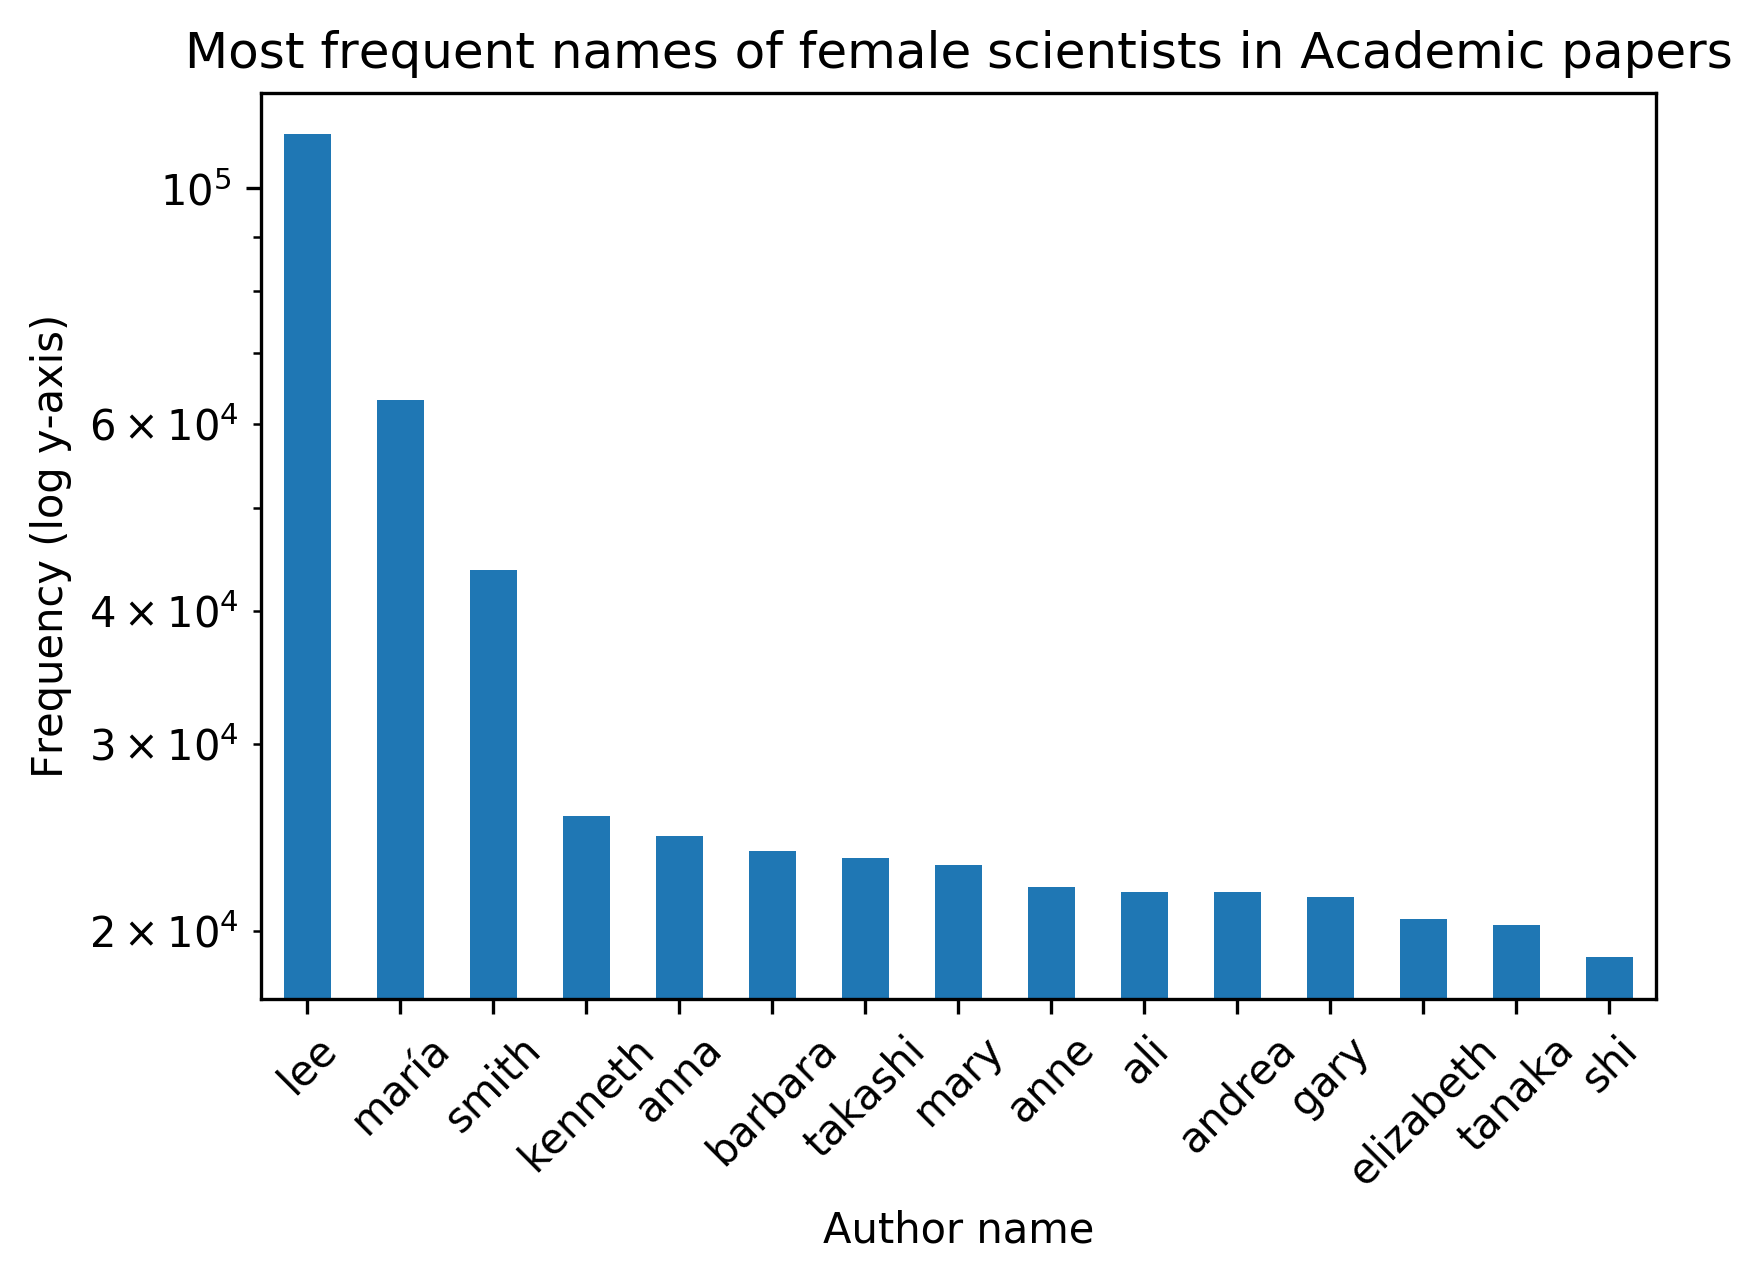

In [22]:
female_scientists = female_scientists.sort_values(by='COUNT(*)', ascending=False)
ax2 = female_scientists[:15].plot(x='Author', y='COUNT(*)', 
                       kind='bar', rot=45, legend=False, logy=True) 
ax2.set_xlabel("Author name");
ax2.set_ylabel("Frequency (log y-axis)");
ax2.set_title("Most frequent names of female scientists in Academic papers");

**Note:** The classification accuracy i.e., the probability of determing correct gender given a name, is dependent on _name2gender_ ML model and the training set used therein. 

### How has the research progressed over the last two decades?

In [25]:
# Find unique journals
unique_journals = pd.read_sql('''
    SELECT TRIM(LOWER(scimag.Journal)) as Journal, COUNT(*) 
    FROM `scimag` 
    WHERE LENGTH(TRIM(Journal))>0
    GROUP BY Journal
    ORDER BY COUNT(*) DESC;
''', con=db);

In [26]:
len(unique_journals)

1588

#### Top 15 journals by quantity of publications over years

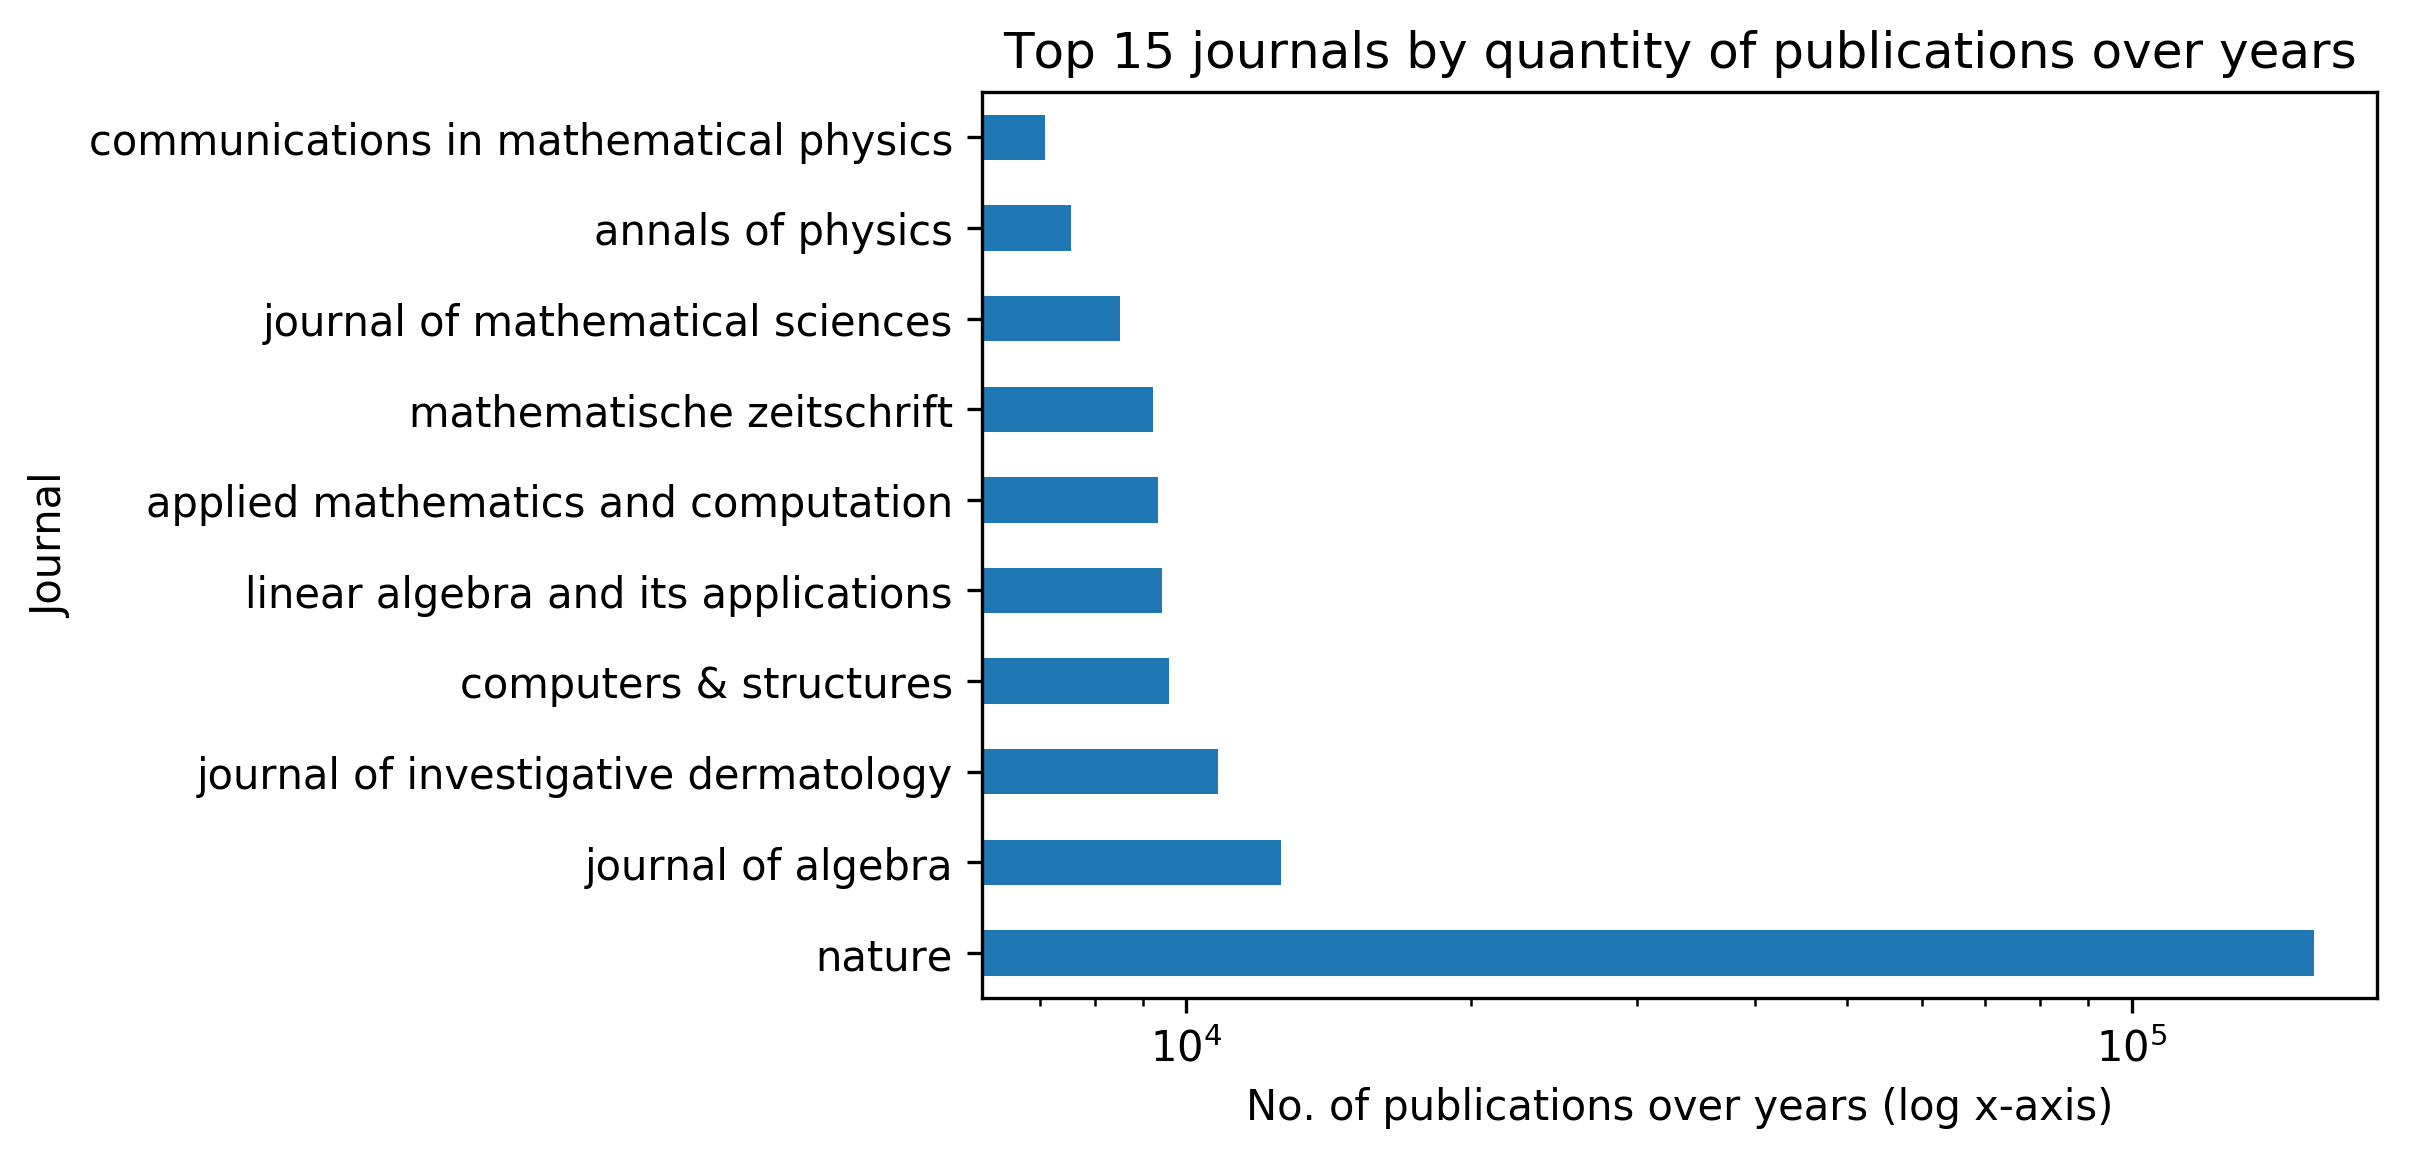

In [50]:
ax_uj = unique_journals[:10].plot(x='Journal', y='COUNT(*)', 
                       kind='barh', rot=0, legend=False, logx=True) 
ax_uj.set_ylabel("Journal");
ax_uj.set_xlabel("No. of publications over years (log x-axis)");
ax_uj.set_title("Top 15 journals by quantity of publications over years");

In [19]:
# Aggregate "quantitative" statistics of journals over the years
journals = pd.read_sql('''
    SELECT scimag.Year, 
      TRIM(LOWER(scimag.Journal)) as Journal, 
      COUNT(*)
    FROM `scimag` 
    WHERE LENGTH(TRIM(Journal))>0
    GROUP BY Journal, Year
    ORDER BY Journal
''', con=db);

In [40]:
# Growth of nature over years
nature = journals[journals['Journal']=='nature']

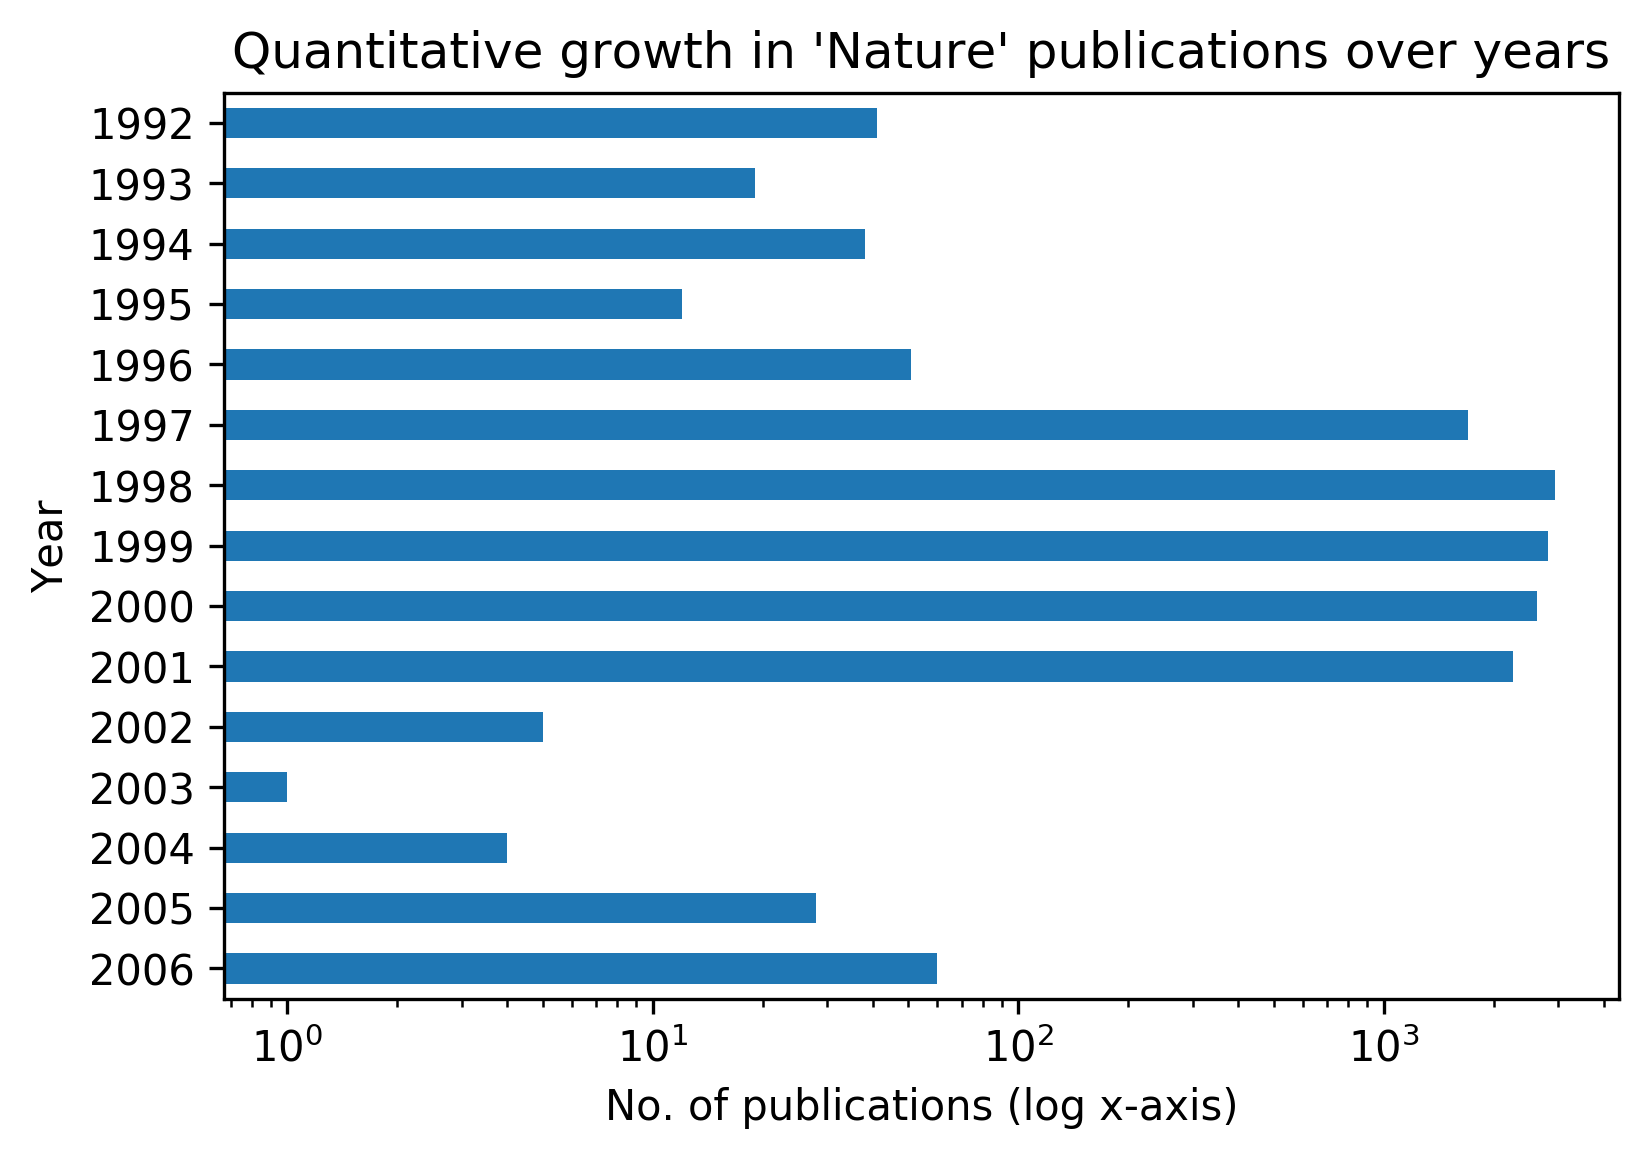

In [51]:
nature_sorted = nature.sort_values(by='Year', ascending=False)
ax_nature = nature_sorted[5:20].plot(x='Year', y='COUNT(*)', 
                       kind='barh', rot=0, legend=False, logx=True) 
ax_nature.set_ylabel("Year");
ax_nature.set_xlabel("No. of publications (log x-axis)");
ax_nature.set_title("Quantitative growth in 'Nature' publications over years");

### Which day/month of the year witnesses most number of publications?

In [53]:
# Aggregate "quantitative" statistics of journal articles published by month 
article_count_by_month = pd.read_sql('''
    SELECT TRIM(LOWER(scimag.Month)) as Month, COUNT(*) 
    FROM `scimag` 
    WHERE LENGTH(TRIM(scimag.Journal))>0 and LENGTH(TRIM(Month))
    GROUP BY Month
    ORDER BY COUNT(*) DESC
''', con=db);

In [155]:
# Need to sanitize data (This is bit ugly)
from datetime import datetime
pd.options.mode.chained_assignment = None
months = [datetime(2008,i,1).strftime('%b') for i in range(1,13)]
acbm = pd.DataFrame(data={
    'Month': [datetime(2008,i,1).strftime('%b') for i in range(1,13)],
    'COUNT(*)': [0]*12
})
m = acbm['COUNT(*)']
for i, month in zip(range(1,13), months):
    if len(article_count_by_month['COUNT(*)'][article_count_by_month['Month']==str(i)]):
        m[i-1] += article_count_by_month['COUNT(*)'][article_count_by_month['Month']==str(i)]
    if len(article_count_by_month['COUNT(*)'][article_count_by_month['Month']=='0'+str(i)]):
        m[i-1] += article_count_by_month['COUNT(*)'][article_count_by_month['Month']=='0'+str(i)]
print(acbm)

   Month  COUNT(*)
0   Jan   30171   
1   Feb   26662   
2   Mar   28599   
3   Apr   26242   
4   May   26598   
5   Jun   26874   
6   Jul   26531   
7   Aug   24716   
8   Sep   26291   
9   Oct   26450   
10  Nov   30420   
11  Dec   27706   


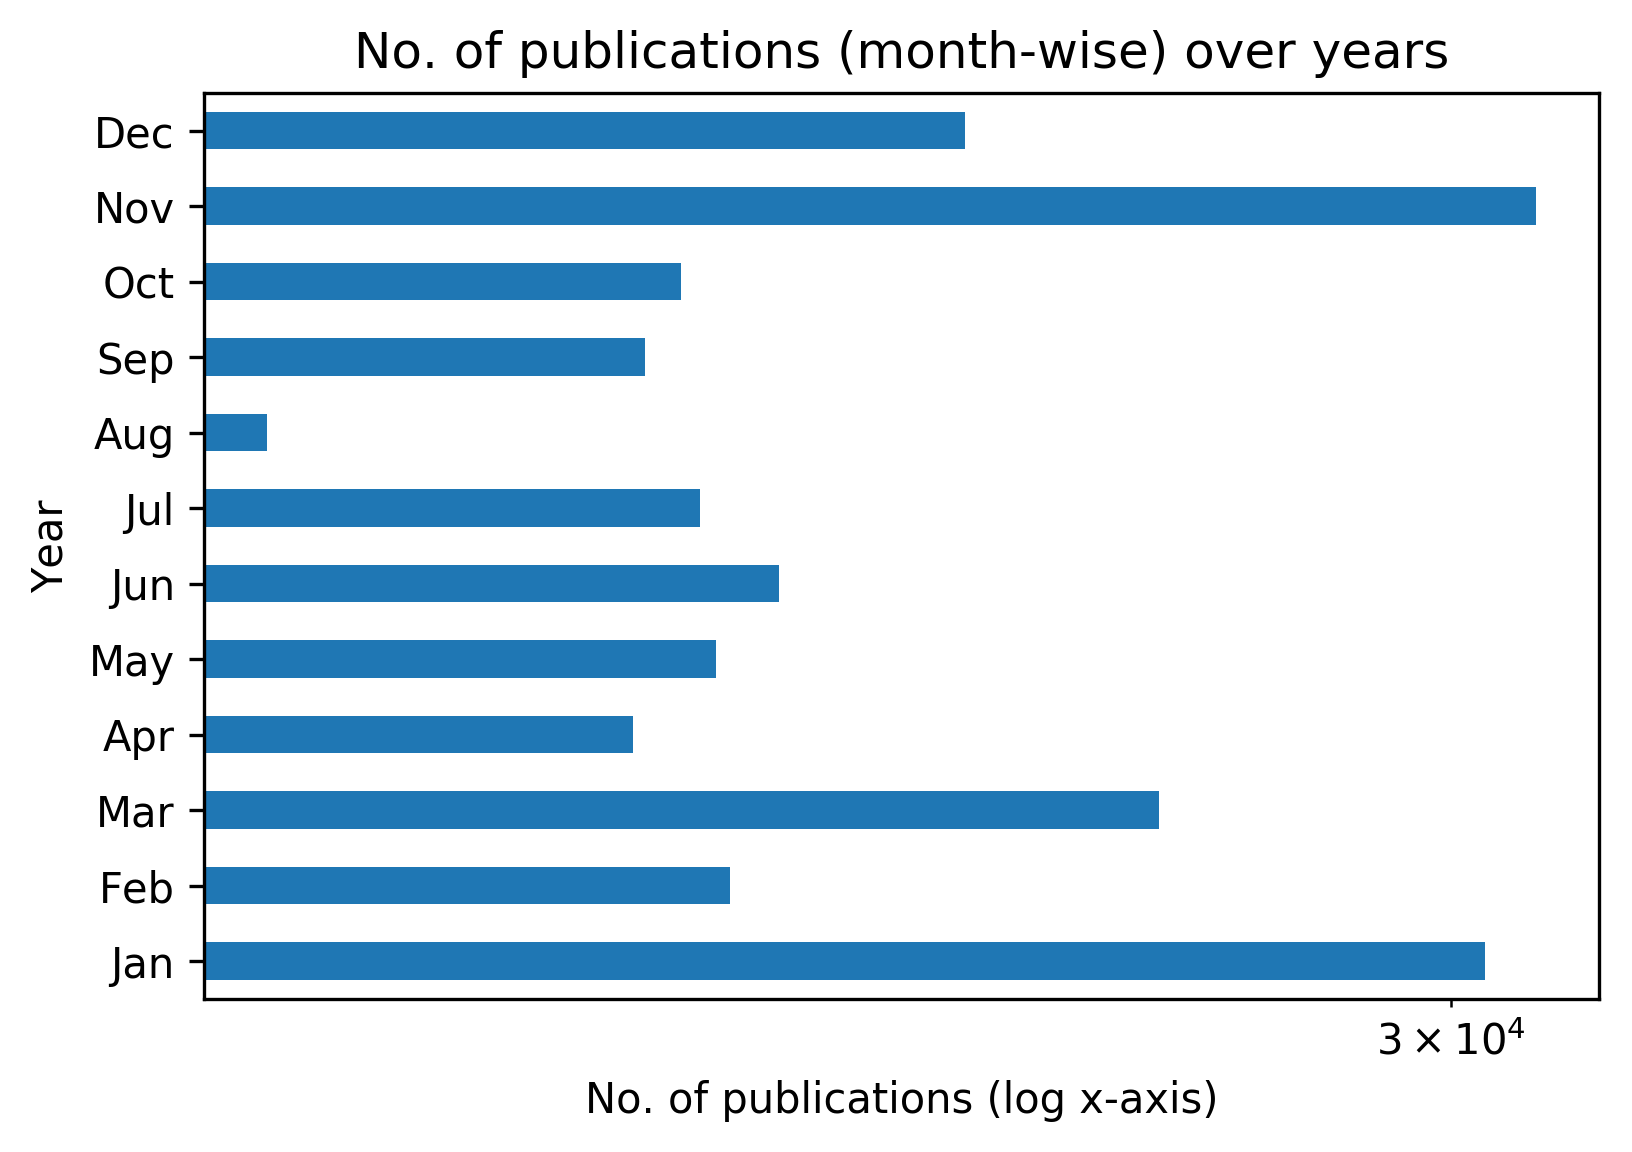

In [174]:
# Plot information
ax_acbm = acbm.plot(x='Month', y='COUNT(*)', 
                       kind='barh', rot=0, legend=False, logx=True) 
ax_acbm.set_ylabel("Year");
ax_acbm.set_xlabel("No. of publications (log x-axis)");
ax_acbm.set_title("No. of publications (month-wise) over years");

### TODO:
* Given the database entries with a pubmed-ID, and hence the abstract information from NIH/PubMed API: 
  * What percentage of these papers are publicly available? 
  * Among those publicly available, how many of them are published under official journal open-access tag
  * Since the inception of open-access journals, how has the research quality and quantity changed?
  * Can we train a model to write abstract of scientific papers given a paper title, or vice-versa i.e., generate a title given the abstract?
  
Knowing the paper title, author list, year of publication; we can crawl enormous information from Google Scholar